## Importación de librerías

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import random

## Carga de datasets

In [12]:
def load_dataset(folder_path):
    dataset = []
    for tag in os.listdir(folder_path):
        tag_path = os.path.join(folder_path, tag)
        if os.path.isdir(tag_path):
            for filename in os.listdir(tag_path):
                image_path = os.path.join(tag_path, filename)
                image = Image.open(image_path)
                image = image.resize((150,150))
                image = np.array(image)
                dataset.append((image, tag))

    random.shuffle(dataset)
    return dataset

In [13]:
train_dataset = load_dataset('seg_train/seg_train')
test_dataset = load_dataset('seg_test/seg_test')

In [14]:
path = "seg_pred/seg_pred"
imagenes = []

for archivo in os.listdir(path):
    if archivo.endswith(".jpg") or archivo.endswith(".jpeg") or archivo.endswith(".png"):
        ruta_archivo = os.path.join(path, archivo)
        image = Image.open(ruta_archivo)
        image = image.resize((150,150))
        image = np.array(image)
        imagenes.append(image)

pred_dataset = np.array(imagenes)
random.shuffle(pred_dataset)

## Preprocesamiento de datos

In [15]:
def procesar_dataset(dataset):
    num_images = len(dataset)
    print("Número total de imágenes:", num_images)

    classes = set([entry[1] for entry in dataset])
    num_classes = len(classes)
    print("Número de clases únicas:", num_classes)

    print("Clases únicas:", classes)

    num_samples = 5
    random_samples = random.sample(dataset, num_samples)

    plt.figure(figsize=(15, 3))

    for i, (image, tag) in enumerate(random_samples):
        if isinstance(image, (Image.Image, np.ndarray)):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(image)
            plt.title(tag)
            plt.axis("off")
        else:
            print(f"La imagen {image} no se cargó correctamente.")

    plt.show()

Número total de imágenes: 14034
Número de clases únicas: 6
Clases únicas: {'mountain', 'glacier', 'buildings', 'street', 'sea', 'forest'}


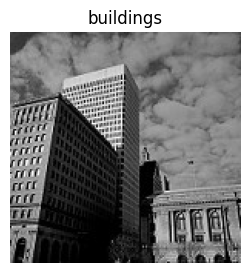

In [16]:
procesar_dataset(train_dataset)

Número total de imágenes: 3000
Número de clases únicas: 6
Clases únicas: {'mountain', 'glacier', 'buildings', 'street', 'sea', 'forest'}


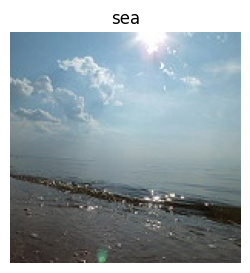

In [17]:
procesar_dataset(test_dataset)

In [18]:
etiquetas_unicas = set([entry[1] for entry in train_dataset])

etiquetas_aleatorias = list(etiquetas_unicas)
random.shuffle(etiquetas_aleatorias)

tags_dict = {tag: i for i, tag in enumerate(etiquetas_aleatorias)}
print("Diccionario de etiquetas:", tags_dict)

train_images = np.array([entry[0] for entry in train_dataset])
train_tags = np.array([tags_dict[entry[1]] for entry in train_dataset])

test_images = np.array([entry[0] for entry in test_dataset])
test_tags = np.array([tags_dict[entry[1]] for entry in test_dataset])

Diccionario de etiquetas: {'glacier': 0, 'forest': 1, 'buildings': 2, 'street': 3, 'sea': 4, 'mountain': 5}


In [19]:
def train_model(model):
    model.compile(optimizer='adam',
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy'])

    model.fit(train_images, train_tags, epochs=20)

def test_model(model):


    test_loss, test_acc = model.evaluate(test_images, test_tags, verbose=2)

    print('\nTest accuracy:', test_acc)

def prediction_distribution(model, images):
    predicciones = model.predict(images)
    etiquetas_predichas = np.argmax(predicciones, axis=1)
    distribucion_predicciones = np.bincount(etiquetas_predichas, minlength=len(tags_dict))

    test_loss, test_acc = model.evaluate(test_images, test_tags, verbose=2)

    nombres_clases = [list(tags_dict.keys())[i] for i in range(len(tags_dict))]

    plt.bar(nombres_clases, distribucion_predicciones)
    plt.xlabel('Tag')
    plt.ylabel('Cantidad de predicciones')
    plt.title('Distribución de predicciones del modelo: {}. Accuracy: {:.2f}'.format(model.name, test_acc))
    plt.xticks(rotation=45)
    plt.show()

## Dense Model

Epoch 1/20
439/439 [==============================] - 4s 5ms/step - loss: 1235.5848 - accuracy: 0.3613
Epoch 2/20
439/439 [==============================] - 2s 4ms/step - loss: 157.2633 - accuracy: 0.4028
Epoch 3/20
439/439 [==============================] - 2s 4ms/step - loss: 19.0865 - accuracy: 0.4106
Epoch 4/20
439/439 [==============================] - 2s 4ms/step - loss: 1.9285 - accuracy: 0.4766
Epoch 5/20
439/439 [==============================] - 2s 4ms/step - loss: 1.5558 - accuracy: 0.4937
Epoch 6/20
439/439 [==============================] - 2s 4ms/step - loss: 1.5890 - accuracy: 0.4803
Epoch 7/20
439/439 [==============================] - 2s 4ms/step - loss: 4.5232 - accuracy: 0.1900
Epoch 8/20
439/439 [==============================] - 2s 4ms/step - loss: 1.7968 - accuracy: 0.1857
Epoch 9/20
439/439 [==============================] - 2s 4ms/step - loss: 1.7815 - accuracy: 0.1889
Epoch 10/20
439/439 [==============================] - 2s 4ms/step - loss: 1.7750 - accuracy: 

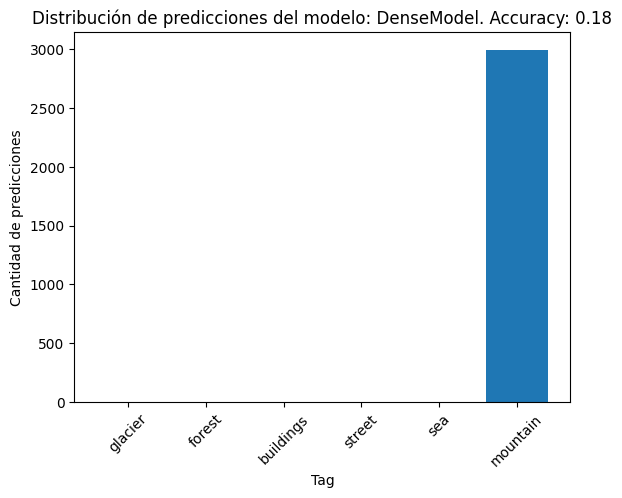

INFO:tensorflow:Assets written to: DenseModel\assets


In [20]:
retrain = True

if retrain or not os.path.exists('DenseModel'):
    DenseModel = tf.keras.models.Sequential(name="DenseModel", layers=
    [
        tf.keras.layers.Flatten(input_shape=(150, 150, 3)),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(6)
    ]
    )
    train_model(DenseModel)
    test_model(DenseModel)
    prediction_distribution(DenseModel, test_images)
    DenseModel.save('DenseModel')
else:
    DenseModel = tf.keras.models.load_model('DenseModel')
    test_model(DenseModel)
    prediction_distribution(DenseModel, test_images)

## Convolutional Model

Epoch 1/20
439/439 [==============================] - 8s 10ms/step - loss: 5.7668 - accuracy: 0.2287
Epoch 2/20
439/439 [==============================] - 4s 9ms/step - loss: 1.6477 - accuracy: 0.3167
Epoch 3/20
439/439 [==============================] - 4s 9ms/step - loss: 1.7846 - accuracy: 0.2255
Epoch 4/20
439/439 [==============================] - 4s 9ms/step - loss: 1.6028 - accuracy: 0.3194
Epoch 5/20
439/439 [==============================] - 4s 9ms/step - loss: 1.2226 - accuracy: 0.5032
Epoch 6/20
439/439 [==============================] - 4s 9ms/step - loss: 0.9432 - accuracy: 0.6102
Epoch 7/20
439/439 [==============================] - 4s 9ms/step - loss: 0.7550 - accuracy: 0.6945
Epoch 8/20
439/439 [==============================] - 4s 9ms/step - loss: 0.6138 - accuracy: 0.7554
Epoch 9/20
439/439 [==============================] - 4s 9ms/step - loss: 0.4912 - accuracy: 0.8027
Epoch 10/20
439/439 [==============================] - 4s 10ms/step - loss: 0.4135 - accuracy: 0.83

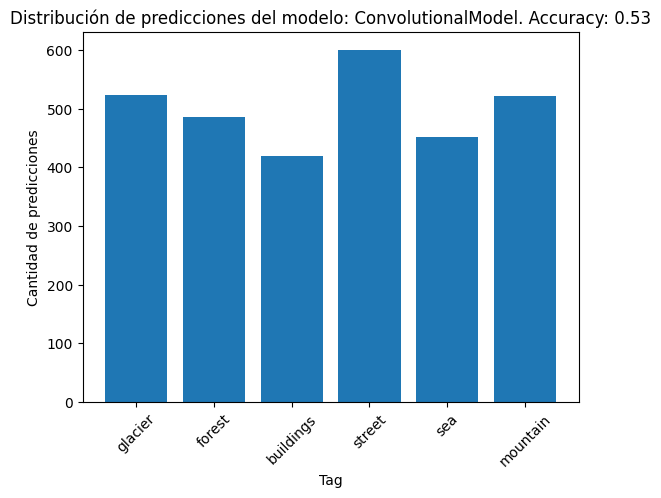

INFO:tensorflow:Assets written to: ConvolutionalModel\assets


INFO:tensorflow:Assets written to: ConvolutionalModel\assets


In [21]:
retrain = False

if retrain or not os.path.exists('ConvolutionalModel'):
    ConvolutionalModel = tf.keras.models.Sequential(name="ConvolutionalModel", layers=
    [
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(6)
    ])
    train_model(ConvolutionalModel)
    test_model(ConvolutionalModel)
    prediction_distribution(ConvolutionalModel, test_images)
    ConvolutionalModel.save('ConvolutionalModel')
else:
    ConvolutionalModel = tf.keras.models.load_model('ConvolutionalModel')
    test_model(ConvolutionalModel)
    prediction_distribution(ConvolutionalModel, test_images)

## ResNet Model

Epoch 1/20
439/439 [==============================] - 10s 17ms/step - loss: 0.3642 - accuracy: 0.8685
Epoch 2/20
439/439 [==============================] - 7s 17ms/step - loss: 0.2417 - accuracy: 0.9153
Epoch 3/20
439/439 [==============================] - 7s 17ms/step - loss: 0.2058 - accuracy: 0.9279
Epoch 4/20
439/439 [==============================] - 7s 17ms/step - loss: 0.1821 - accuracy: 0.9339
Epoch 5/20
439/439 [==============================] - 8s 19ms/step - loss: 0.1618 - accuracy: 0.9416
Epoch 6/20
439/439 [==============================] - 8s 19ms/step - loss: 0.1516 - accuracy: 0.9456
Epoch 7/20
439/439 [==============================] - 9s 19ms/step - loss: 0.1372 - accuracy: 0.9503
Epoch 8/20
439/439 [==============================] - 16s 37ms/step - loss: 0.1300 - accuracy: 0.9513
Epoch 9/20
439/439 [==============================] - 44s 100ms/step - loss: 0.1215 - accuracy: 0.9570
Epoch 10/20
439/439 [==============================] - 9s 21ms/step - loss: 0.1141 - ac

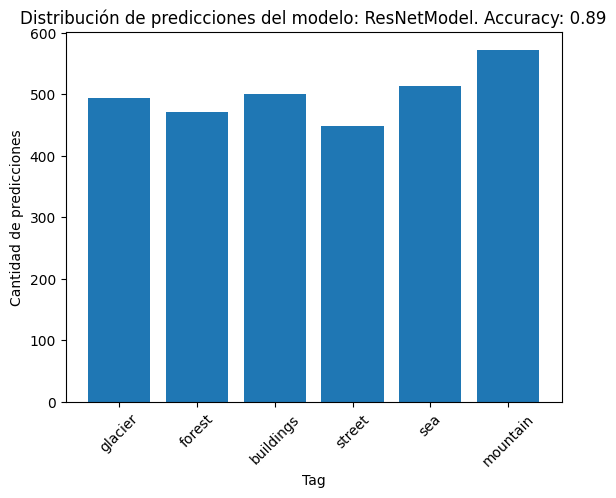

INFO:tensorflow:Assets written to: ResNetModel\assets


INFO:tensorflow:Assets written to: ResNetModel\assets


In [22]:
retrain = False

if retrain or not os.path.exists('ResNetModel'):
    model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(150, 150, 3)
    )

    model.trainable = False

    ResNetModel = tf.keras.models.Sequential(name="ResNetModel", layers=
    [
        model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(6)
    ])
    train_model(ResNetModel)
    test_model(ResNetModel)
    prediction_distribution(ResNetModel, test_images)
    ResNetModel.save('ResNetModel')
else:
    ResNetModel = tf.keras.models.load_model('ResNetModel')
    test_model(ResNetModel)
    prediction_distribution(ResNetModel, test_images)

## Inception Model

Epoch 1/20
439/439 [==============================] - 75s 151ms/step - loss: 0.3539 - accuracy: 0.8787
Epoch 2/20
439/439 [==============================] - 135s 307ms/step - loss: 0.2158 - accuracy: 0.9250
Epoch 3/20
439/439 [==============================] - 462s 1s/step - loss: 0.1642 - accuracy: 0.9411
Epoch 4/20
439/439 [==============================] - 729s 2s/step - loss: 0.1511 - accuracy: 0.9484
Epoch 5/20
439/439 [==============================] - 893s 2s/step - loss: 0.1149 - accuracy: 0.9562
Epoch 6/20
439/439 [==============================] - 1173s 3s/step - loss: 0.1107 - accuracy: 0.9617
Epoch 7/20
439/439 [==============================] - 944s 2s/step - loss: 0.0895 - accuracy: 0.9705
Epoch 8/20
439/439 [==============================] - 38s 86ms/step - loss: 0.0824 - accuracy: 0.9727
Epoch 9/20
439/439 [==============================] - 32s 73ms/step - loss: 0.0711 - accuracy: 0.9761
Epoch 10/20
439/439 [==============================] - 32s 74ms/step - loss: 0.0682

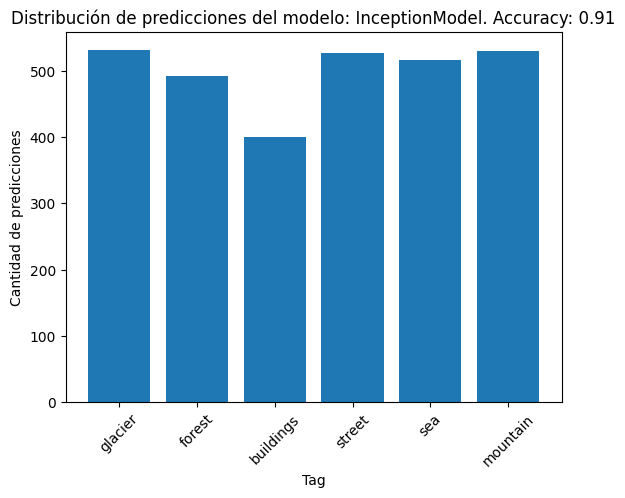

TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [23]:
retrain = False

if retrain or not os.path.exists('InceptionModel.h5'):
    model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(150, 150, 3)
    )

    model.trainable = True

    InceptionModel = tf.keras.models.Sequential(name="InceptionModel", layers=
    [
        model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(6)
    ])
    train_model(InceptionModel)
    test_model(InceptionModel)
    prediction_distribution(InceptionModel, test_images)
    InceptionModel.save("InceptionModel") #Este comando no funciona bien con Tensorflow 2.10 y 2.11, se recomienda usar 2.9
else:
    InceptionModel = tf.keras.models.load_model("InceptionModel")
    test_model(InceptionModel)
    prediction_distribution(InceptionModel, test_images)

## Comparaciones y conclusiones finales

229/229 [==============================] - 0s 2ms/step
94/94 - 0s - loss: 2.1000 - accuracy: 0.1760 - 212ms/epoch - 2ms/step


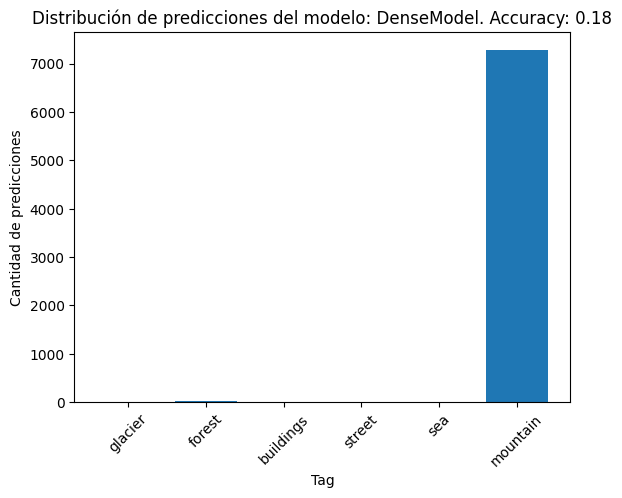

229/229 [==============================] - 0s 2ms/step


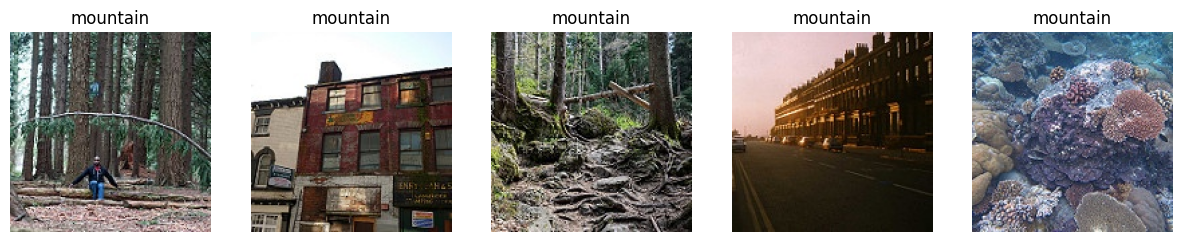

229/229 [==============================] - 1s 5ms/step
94/94 - 1s - loss: 4.2360 - accuracy: 0.5267 - 526ms/epoch - 6ms/step


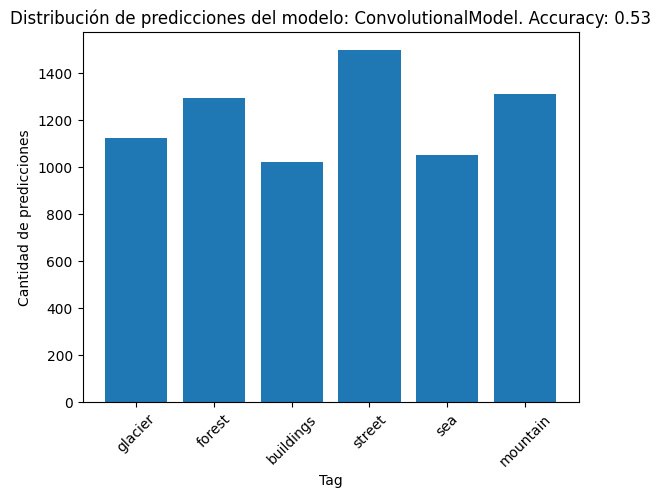

229/229 [==============================] - 1s 5ms/step


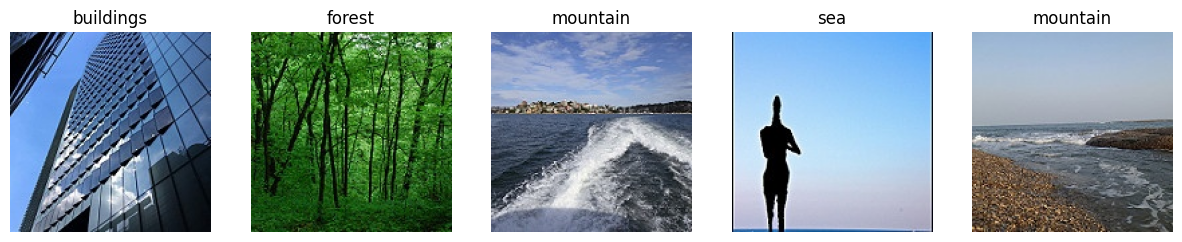

229/229 [==============================] - 6s 26ms/step
94/94 - 3s - loss: 0.3814 - accuracy: 0.8903 - 3s/epoch - 32ms/step


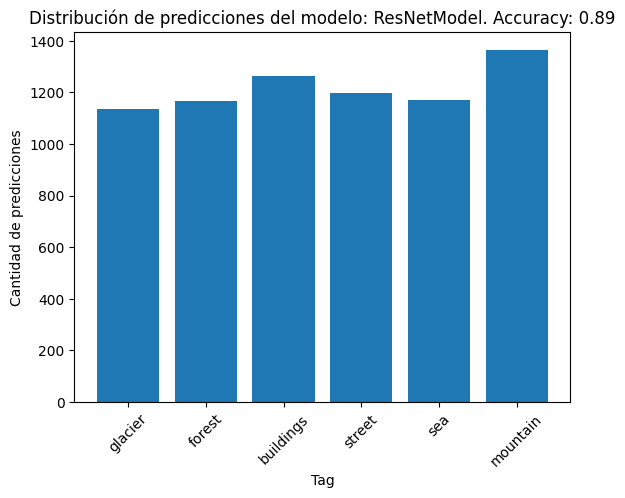

229/229 [==============================] - 7s 32ms/step


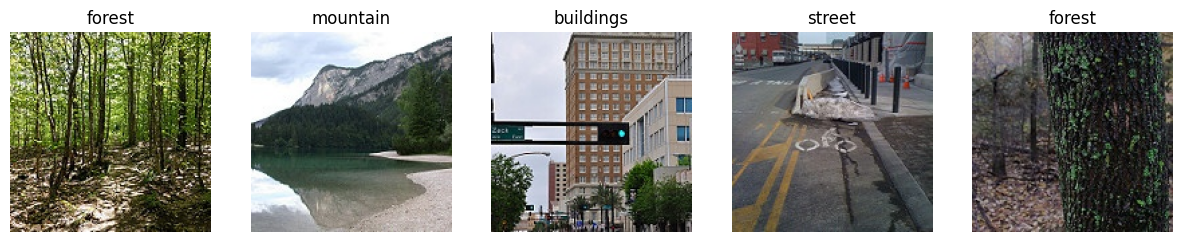

229/229 [==============================] - 5s 21ms/step
94/94 - 2s - loss: 0.3863 - accuracy: 0.9120 - 2s/epoch - 22ms/step


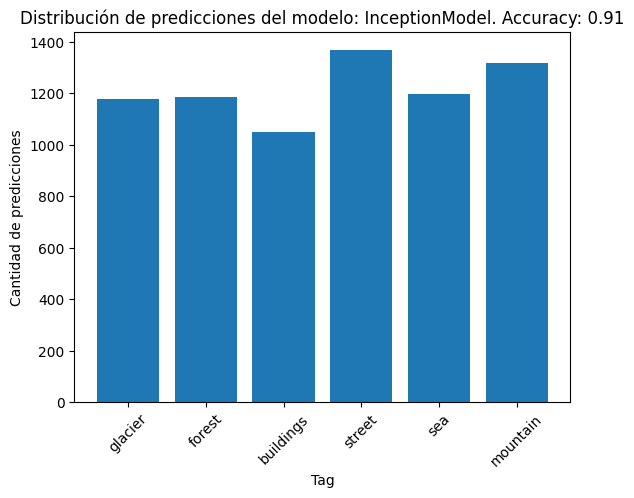

229/229 [==============================] - 5s 21ms/step


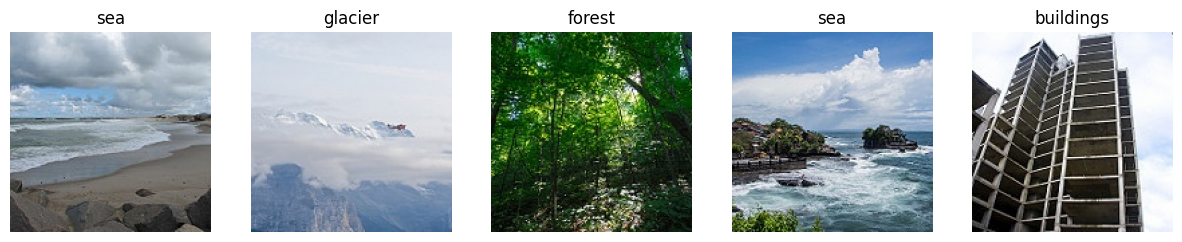

In [29]:
## Distribuciones entre modelos
def mostrar_predicciones(modelo, imagenes, tags_dict):
    predicciones = modelo.predict(imagenes)
    etiquetas_predichas = np.argmax(predicciones, axis=1)
    
    indices_aleatorios = np.random.choice(len(imagenes), 5, replace=False)
    
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))  # Crear una fila de 5 subtramas
    
    for i, indice in enumerate(indices_aleatorios):
        imagen = imagenes[indice]
        etiqueta_predicha = etiquetas_predichas[indice]
        nombre_etiqueta_predicha = list(tags_dict.keys())[etiqueta_predicha]
        
        axs[i].imshow(imagen)
        axs[i].axis('off')
        axs[i].set_title(f'{nombre_etiqueta_predicha}')

    plt.show()

prediction_distribution(DenseModel, pred_dataset)
mostrar_predicciones(DenseModel, pred_dataset, tags_dict)
prediction_distribution(ConvolutionalModel, pred_dataset)
mostrar_predicciones(ConvolutionalModel, pred_dataset, tags_dict)
prediction_distribution(ResNetModel, pred_dataset)
mostrar_predicciones(ResNetModel, pred_dataset, tags_dict)
prediction_distribution(InceptionModel, pred_dataset)
mostrar_predicciones(InceptionModel, pred_dataset, tags_dict)

Podemos notar como el modelo Inception reentrenado es el que mejor se comporta en términos de accuracy y loss, seguido por el modelo ResNet. El siguiente con mejor desempeño es el modelo Convolucional. En último lugar encontramos al modelo Dense, que no consigue diferenciar entre las distintas clases de imágenes. Esto puede deberse a la simplicidad del modelo y la incapacidad de aprender las características de las imágenes con tan poca profundidad.